# *Less Effective* LSTM Model - Median Hourly Wage ($)

**Difference:** *RMSprop optimizer*

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

# Packages

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import gdown
import requests
from io import StringIO
import time

In [2]:
# Show graphs
%matplotlib inline

## Data Loading

In [3]:
# Google Drive file
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  

# Load the CSV directly into df
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

# Display data
print('Shape of the dataset:', df.shape)
print(df.dtypes)

Shape of the dataset: (349920, 14)
ref_date                   object
geo                        object
labour_force               object
industry                   object
sex                        object
age_group                  object
value_unemployment        float64
wages                      object
value_wage                float64
year                        int64
month                       int64
ref_date_numeric          float64
value_unemployment_log    float64
value_wage_log            float64
dtype: object


In [4]:
# Create a copy with selected columns
df_var = df[['ref_date', 'value_wage']].copy()

# Group df_var by 'ref_date' and calculate the median 'value_wage'
df_lstm = df_var.groupby('ref_date').agg(
    median_wage=('value_wage', 'median')  # Calculate the median 
).reset_index()

print(df_lstm)

       ref_date  median_wage
0    1997-01-01    12.375000
1    1997-02-01    12.695000
2    1997-03-01    12.511667
3    1997-04-01    12.585000
4    1997-05-01    12.000000
..          ...          ...
319  2023-08-01    26.037639
320  2023-09-01    27.000000
321  2023-10-01    26.670000
322  2023-11-01    27.000000
323  2023-12-01    27.400000

[324 rows x 2 columns]


## Model Preparation

In [5]:
# Convert 'ref_date' to datetime
df_lstm['ref_date'] = pd.to_datetime(df_lstm['ref_date'])

# Set 'ref_date' as the index 
df_lstm.set_index('ref_date', inplace=True)

# Verify the index is set and DatetimeIndex
print('\n\nIndex after setting ref_date:\n', df_lstm.head().index)
print('\n\nData types after setting index:\n', df_lstm.dtypes)
print('\n\nDataset:\n', df_lstm.head(2))



Index after setting ref_date:
 DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01'],
              dtype='datetime64[ns]', name='ref_date', freq=None)


Data types after setting index:
 median_wage    float64
dtype: object


Dataset:
             median_wage
ref_date               
1997-01-01       12.375
1997-02-01       12.695


## Training & Testing Sets

In [6]:
# Split the data into training and testing sets
train = df_lstm['1997-01-01':'2020-12-01']
test = df_lstm['2021-01-01':'2023-12-01']

## Standardize Data

In [7]:
# Standardize the training and testing data
scaler = StandardScaler()

# Fit on the training data and transform both training and testing datasets
train_std = scaler.fit_transform(train[['median_wage']])
test_std = scaler.transform(test[['median_wage']])
  
# Function to create sequences for forecasting
def create_sequences(data, seq_length):
    xs, ys = [], []
    # Ensure data is 2D to allow proper indexing for sequences
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    # Loop through the data to create sequences of length seq_length
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]  # Sequence of length 'seq_length'
        y = data[i+seq_length, 0]  # Target value right after the sequence
        xs.append(x)
        ys.append(y)
    
    # Include the last sequence even if it doesn't reach the end
    x_last = data[len(data) - seq_length:]  # Last sequence (12 months of data)
    y_last = data[len(data) - 1, 0]  # Target for the last sequence (next data point)
    xs.append(x_last)
    ys.append(y_last)
    
    return np.array(xs), np.array(ys)

# Define sequence length
SEQ_LENGTH = 12

# Create training and testing sequences
train_x, train_y = create_sequences(train_std, SEQ_LENGTH)
test_x, test_y = create_sequences(test_std, SEQ_LENGTH)

# Reshape to 3D for LSTM: (samples, time steps, features)
train_x_reshaped = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
test_x_reshaped = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

# Print the shapes to confirm
print("Shape of train_x_reshaped:", train_x_reshaped.shape)  
print("Shape of test_x_reshaped:", test_x_reshaped.shape)   

Shape of train_x_reshaped: (277, 12, 1)
Shape of test_x_reshaped: (25, 12, 1)


## Cross Validation

In [8]:
# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_mae_scores = []
cv_rmse_scores = []
cv_mape_scores = []

# Define model 
model_cv = Sequential()
model_cv.add(Input(shape=(SEQ_LENGTH, 1)))
model_cv.add(LSTM(32, activation='relu'))
model_cv.add(Dropout(0.2))
model_cv.add(Dense(1, activation='linear'))

# Compile model before the loop
model_cv.compile(optimizer='RMSprop', loss='mse')

for train_index, val_index in tscv.split(train_std):
    # Split standardized data into training and validation for each fold
    train_x_cv, train_y_cv = create_sequences(train_std[train_index], SEQ_LENGTH)
    val_x_cv, val_y_cv = create_sequences(train_std[val_index], SEQ_LENGTH)

    # Reshape to 3D for LSTM: (samples, time steps, features)
    train_x_cv_reshaped = train_x_cv.reshape((train_x_cv.shape[0], train_x_cv.shape[1], 1))
    val_x_cv_reshaped = val_x_cv.reshape((val_x_cv.shape[0], val_x_cv.shape[1], 1))

    # Train model
    start = time.time()
    history = model_cv.fit(train_x_cv_reshaped, train_y_cv, epochs=200, batch_size=32, validation_data=(val_x_cv_reshaped, val_y_cv), verbose=0)
    end = time.time()

    # Predict on validation data
    val_predictions = model_cv.predict(val_x_cv_reshaped)

    # Flatten predictions and target values for metric functions
    val_predictions_flattened = val_predictions.flatten()
    val_y_cv_flattened = val_y_cv.flatten()

    # Inverse transform the predicted and actual values back to the original scale
    val_predictions_inv = scaler.inverse_transform(val_predictions_flattened.reshape(-1, 1))
    val_y_cv_inv = scaler.inverse_transform(val_y_cv_flattened.reshape(-1, 1))

    # Calculate MAPE on the unscaled data
    epsilon = 1e-10  # Small value to avoid division by zero
    val_mape = mean_absolute_percentage_error(val_y_cv_inv + epsilon, val_predictions_inv + epsilon)

    # Calculate MAE, RMSE, and MAPE for validation set
    val_mae = mean_absolute_error(val_y_cv_inv, val_predictions_inv)
    val_rmse = np.sqrt(mean_squared_error(val_y_cv_inv, val_predictions_inv))

    # Append scores to corresponding lists
    cv_mae_scores.append(val_mae)
    cv_rmse_scores.append(val_rmse)
    cv_mape_scores.append(val_mape)

    print('\nValidation Set Results')
    print(f"Validation MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, MAPE: {val_mape * 100:.2f}%, Training time: {end - start:.2f} seconds")

# Print Cross-Validation Mean Scores
print('\nMean Overall Scores')
print('Cross-Validation Mean Absolute Error (MAE):', np.mean(cv_mae_scores))
print('Cross-Validation Root Mean Squared Error (RMSE):', np.mean(cv_rmse_scores))
print('Cross-Validation Mean Absolute Percentage Error (MAPE):', np.mean(cv_mape_scores))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step

Validation Set Results
Validation MAE: 0.44, RMSE: 0.56, MAPE: 3.11%, Training time: 11.94 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Validation Set Results
Validation MAE: 1.06, RMSE: 1.22, MAPE: 6.20%, Training time: 10.54 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Validation Set Results
Validation MAE: 1.89, RMSE: 2.00, MAPE: 9.67%, Training time: 11.33 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Validation Set Results
Validation MAE: 0.40, RMSE: 0.48, MAPE: 1.90%, Training time: 11.68 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Validation Set Results
Validation MAE: 0.49, RMSE: 0.61, MAPE: 2.08%, Training time: 12.15 seconds

Mean Overall Scores
Cross-Validation Mean Absolute Error (MAE): 0.8565749054910798
Cross-Validation Root Mean Squared Error (RMSE): 0.972711744063113
Cross-Validation Mean Absolute Percentage Error (MAPE): 0.04591160976077615


# Training Model

In [9]:
train_mae_scores = []
train_rmse_scores = []
train_mape_scores = []

# Train model on full training set
model_train = Sequential()
model_train.add(Input(shape=(SEQ_LENGTH, 1)))
model_train.add(LSTM(32, activation='relu'))
model_train.add(Dropout(0.2))
model_train.add(Dense(1, activation='linear'))

# Compile model before the loop
model_train.compile(optimizer='RMSprop', loss='mse')

print(model_train.summary())

# Train model on the entire training set
start = time.time()
history = model_train.fit(train_x_reshaped, train_y, epochs=200, batch_size=32, validation_data=(val_x_cv_reshaped, val_y_cv), verbose=0)
end = time.time()

# Predict on the full training data 
train_predictions = model_train.predict(train_x_reshaped)

# Flatten predictions and target values for metric functions
train_predictions_flattened = train_predictions.flatten()
train_y_flattened = train_y.flatten()

# Inverse transform the predicted and actual values back to the original scale
train_predictions_inv = scaler.inverse_transform(train_predictions_flattened.reshape(-1, 1))  # Inverse transform predictions
train_y_inv = scaler.inverse_transform(train_y_flattened.reshape(-1, 1))  # Inverse transform true values

# Calculate MAE, RMSE, and MAPE for the whole training set
train_mae = mean_absolute_error(train_y_inv, train_predictions_inv)
train_rmse = np.sqrt(mean_squared_error(train_y_inv, train_predictions_inv))

# Add a small epsilon to avoid division by zero in MAPE calculation
epsilon = 1e-10  # Small value to avoid division by zero
train_mape = mean_absolute_percentage_error(train_y_inv + epsilon, train_predictions_inv + epsilon)

# Append scores to corresponding lists
train_mae_scores.append(train_mae)
train_rmse_scores.append(train_rmse)
train_mape_scores.append(train_mape)

# Output training results
print('\nTraining Set Results')
print(f"Training MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, MAPE: {train_mape * 100:.2f}%, Training time: {end - start:.2f} seconds")

# Print Mean Scores for the whole training set
print('\nMean Overall Scores')
print('Training Mean Absolute Error (MAE):', np.mean(train_mae_scores))
print('Training Root Mean Squared Error (RMSE):', np.mean(train_rmse_scores))
print('Training Mean Absolute Percentage Error (MAPE):', np.mean(train_mape_scores))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Training Set Results
Training MAE: 0.34, RMSE: 0.43, MAPE: 1.94%, Training time: 14.31 seconds

Mean Overall Scores
Training Mean Absolute Error (MAE): 0.34188197461795433
Training Root Mean Squared Error (RMSE): 0.43319629832324075
Training Mean Absolute Percentage Error (MAPE): 0.019363736359961584


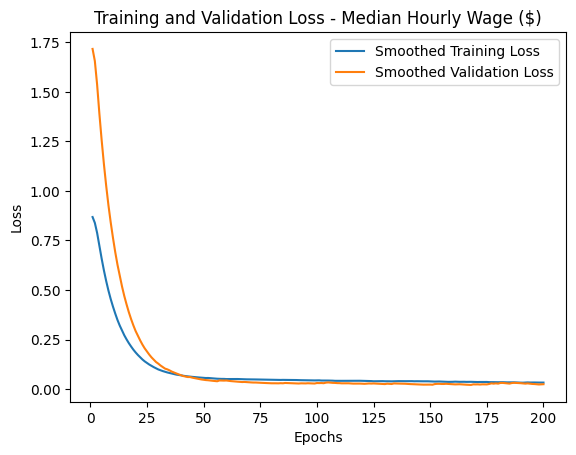

Best epoch based on validation loss: 168


In [10]:
# Retrieve loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define smoothing function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth loss curves
smoothed_loss = smooth_curve(loss)
smoothed_val_loss = smooth_curve(val_loss)

# Plot smoothed training and validation loss
plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, label='Smoothed Training Loss')
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, label='Smoothed Validation Loss')
plt.title('Training and Validation Loss - Median Hourly Wage ($)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Identify epoch with the lowest validation loss
best_epoch = np.argmin(smoothed_val_loss) + 1
print(f"Best epoch based on validation loss: {best_epoch}")

In [11]:
train_final_mae_scores = []
train_final_rmse_scores = []
train_final_mape_scores = []

# Train model on the full training set
model_train_final = Sequential()
model_train_final.add(Input(shape=(SEQ_LENGTH, 1)))
model_train_final.add(LSTM(32, activation='relu'))
model_train_final.add(Dropout(0.2))
model_train_final.add(Dense(1, activation='linear'))

# Compile model before the loop
model_train_final.compile(optimizer='RMSprop', loss='mse')

print(model_train_final.summary())

# Train model on the entire training set
start = time.time()
history = model_train_final.fit(train_x_reshaped, train_y, epochs=best_epoch, batch_size=32, verbose=0)
end = time.time()

# Predict on the full training data 
train_final_predictions = model_train_final.predict(train_x_reshaped)

# Flatten predictions and target values to be compatible with metric functions
train_final_predictions_flattened = train_final_predictions.flatten()
train_final_y_flattened = train_y.flatten()

# Inverse transform the predicted and actual values back to the original scale
train_final_predictions_inv = scaler.inverse_transform(train_final_predictions_flattened.reshape(-1, 1))  # Inverse transform predictions
train_final_y_inv = scaler.inverse_transform(train_final_y_flattened.reshape(-1, 1))  # Inverse transform true values

# Calculate MAE, RMSE, and MAPE for the whole training set
train_final_mae = mean_absolute_error(train_final_y_inv, train_final_predictions_inv)
train_final_rmse = np.sqrt(mean_squared_error(train_final_y_inv, train_final_predictions_inv))

# Add a small epsilon to avoid division by zero in MAPE calculation
epsilon = 1e-10  # Small value to avoid division by zero
train_final_mape = mean_absolute_percentage_error(train_final_y_inv + epsilon, train_final_predictions_inv + epsilon)

# Append scores to corresponding lists
train_final_mae_scores.append(train_final_mae)
train_final_rmse_scores.append(train_final_rmse)
train_final_mape_scores.append(train_final_mape)

# Output training results
print('\nTraining Set Results')
print(f"Training MAE: {train_final_mae:.2f}, RMSE: {train_final_rmse:.2f}, MAPE: {train_final_mape * 100:.2f}%, Training time: {end - start:.2f} seconds")

# Print Mean Scores for the whole training set
print('\nMean Overall Scores')
print('Training Mean Absolute Error (MAE):', np.mean(train_final_mae_scores))
print('Training Root Mean Squared Error (RMSE):', np.mean(train_final_rmse_scores))
print('Training Mean Absolute Percentage Error (MAPE):', np.mean(train_final_mape_scores))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Training Set Results
Training MAE: 0.37, RMSE: 0.45, MAPE: 2.13%, Training time: 8.23 seconds

Mean Overall Scores
Training Mean Absolute Error (MAE): 0.3694132086950744
Training Root Mean Squared Error (RMSE): 0.45218812006110826
Training Mean Absolute Percentage Error (MAPE): 0.021337712961099858


# Final Model Evaluation

In [12]:
# Verify test_x and test_y shape
print("Shape of test_x:", test_x.shape)  # Should be (25, 12, 1)
print("Shape of test_y before reshaping:", test_y.shape)  # Should be (25,)

# Reshape test_y to (25, 1) for evaluation 
test_y_reshaped = test_y.reshape(-1, 1)  # Reshape from (25,) to (25, 1)

# Verify new shape of test_y
print("Shape of test_y after reshaping:", test_y_reshaped.shape)  # Should be (25, 1)

# Compile the model before using it for evaluation
model_train_final.compile(optimizer='RMSprop', loss='mse')

# Evaluate model with reshaped test_y
loss = model_train_final.evaluate(test_x, test_y_reshaped)
print(f'\nTest Loss (MSE): {loss}')  

# Make predictions on the test set
predictions = model_train_final.predict(test_x)

# Flatten predictions and target values for metric functions
predictions_flattened = predictions.flatten()
test_y_reshaped_flattened = test_y_reshaped.flatten()

# Add epsilon to avoid division by zero in MAPE calculation
epsilon = 1e-10  # Small value to avoid division by zero

# Inverse transform the predictions and actual values back to the original scale
predictions_inv = scaler.inverse_transform(predictions_flattened.reshape(-1, 1))  # Inverse transform predictions
y_test_inv = scaler.inverse_transform(test_y_reshaped_flattened.reshape(-1, 1))  # Inverse transform true values

# Calculate MAE, RMSE, and MAPE for the whole test set
mae = mean_absolute_error(y_test_inv, predictions_inv)
mse = mean_squared_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mse)

# Calculate MAPE using inverse transformed values
mape = mean_absolute_percentage_error(y_test_inv + epsilon, predictions_inv + epsilon)

# Output evaluation metrics
print('\nModel Evaluation Metrics')
print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape * 100:.2f}%\n")  

# Inverse transformation function 
def inverse_transform(data, scaler, reference_data):
    return scaler.inverse_transform(np.concatenate((data, np.zeros((data.shape[0], reference_data.shape[1] - 1))), axis=1))[:, 0]

# Compare actual vs predicted after inverse transformation
comparison = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': predictions_inv.flatten()})
print(comparison.head())

Shape of test_x: (25, 12, 1)
Shape of test_y before reshaping: (25,)
Shape of test_y after reshaping: (25, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0148

Test Loss (MSE): 0.014816904440522194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

Model Evaluation Metrics
Test MAE: 0.35
Test MSE: 0.21
Test RMSE: 0.46
Test MAPE: 1.34%

      Actual  Predicted
0  25.063571  25.169083
1  25.695714  25.211782
2  25.553571  25.231432
3  25.000000  25.004416
4  25.000000  24.719206


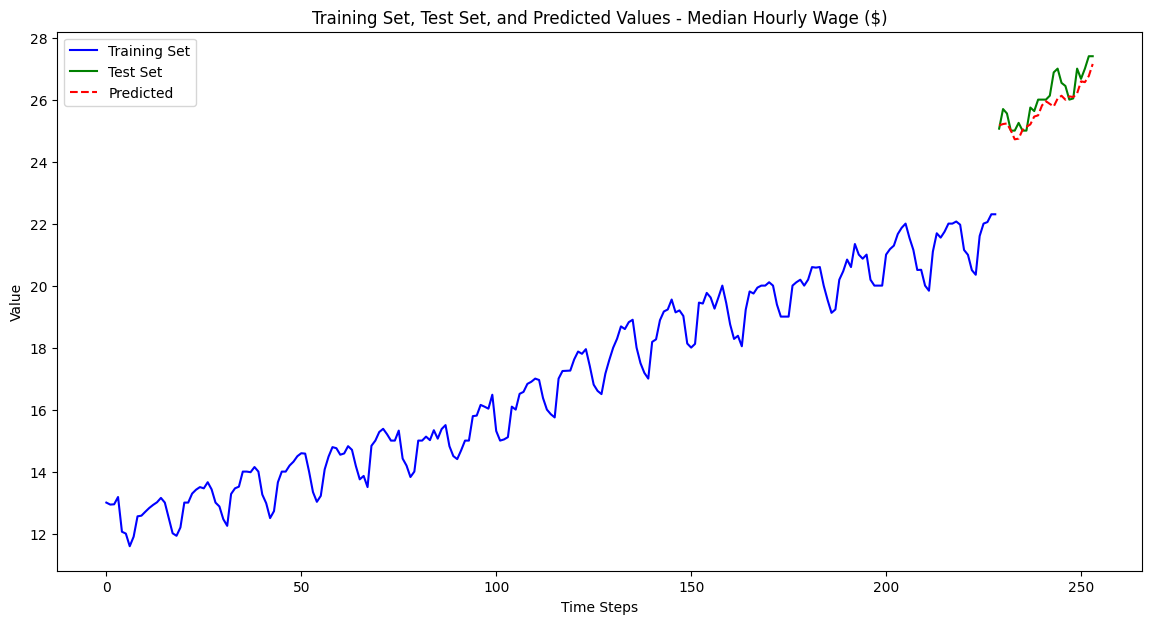

In [13]:
# Plotting the training set, test set, and predicted values
plt.figure(figsize=(14, 7))

# Assuming train_y, test_y are the actual train and test sets
train_y_inv = inverse_transform(train_y_cv.reshape(-1, 1), scaler, train_std)

# Plot training set
plt.plot(range(len(train_y_inv)), train_y_inv, label='Training Set', color='blue')

# Plot test set
plt.plot(range(len(train_y_inv), len(train_y_inv) + len(y_test_inv)), y_test_inv, label='Test Set', color='green')

# Plot predicted values
plt.plot(range(len(train_y_inv), len(train_y_inv) + len(predictions_inv)), predictions_inv, label='Predicted', color='red', linestyle='--')

plt.title('Training Set, Test Set, and Predicted Values - Median Hourly Wage ($)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()